In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

from statsmodels.formula.api import ols

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, Adamax

from tensorflow.keras.layers import Dense, Concatenate, Activation
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [2]:
#aa = "A01"
#aa = "A02"
#aa = "A03"
aa = "A04"
#aa = "A05"
#aa = "A06"
A0=pd.read_csv(aa+".csv",encoding="utf-8-sig")

In [3]:
A0["de_dt"] = pd.to_datetime(A0["de_dt"].astype(int).astype(str))
A0

,cust,pd_c,cop_c,de_dt,de_hr,buy_am,ma_fem_dv,ages,pd_nm,clac_hlv_nm,clac_mcls_nm
0,M805544172,PD1171,A04,2021-01-01,15,1200.0,남성,50대,일반두유,음료,두유
1,M805544172,PD0529,A04,2021-01-01,15,100.0,남성,50대,기타생활서비스,생활/렌탈서비스,생활서비스
2,M825753792,PD1179,A04,2021-01-01,16,3000.0,여성,20대,일반차음료,음료,차음료
3,M825753792,PD1179,A04,2021-01-01,16,1500.0,여성,20대,일반차음료,음료,차음료
4,M312127414,PD0230,A04,2021-01-01,13,1344.0,여성,50대,옥수수스낵,과자,스낵류
...,...,...,...,...,...,...,...,...,...,...,...
316477,M583757333,PD0147,A04,2021-12-31,23,14600.0,여성,40대,건전지,공구/안전용품,전기용품
316478,M272555450,PD0354,A04,2021-12-31,22,2000.0,여성,50대,냉장핫도그/핫바류,냉장식품,냉장간편식
316479,M272555450,PD0414,A04,2021-12-31,22,1600.0,여성,50대,비빔용기라면,대용식,용기라면
316480,M272555450,PD0282,A04,2021-12-31,22,100.0,여성,50대,봉투보증금,기타(비상품),기타


# 전처리

## 점수 base 생성

In [4]:
#raitings : 고객 별 상품 구매 횟수 count (대분류는 덤으로!)
A0_tmp = A0.value_counts(['cust','pd_c',"de_dt","clac_mcls_nm","clac_hlv_nm"]).reset_index().rename(columns={0:"buy_am"})
ratings=A0_tmp.groupby(['cust','pd_c',"clac_mcls_nm","clac_hlv_nm"],as_index=False).count()[['cust','pd_c',"clac_mcls_nm","clac_hlv_nm",'buy_am']]
ratings

,cust,pd_c,clac_mcls_nm,clac_hlv_nm,buy_am
0,M000034966,PD1161,과채음료,음료,1
1,M000034966,PD1165,기능성음료,음료,1
2,M000034966,PD1330,맥주,주류,1
3,M000201112,PD0217,비스킷류,과자,1
4,M000201112,PD0220,비스킷류,과자,1
...,...,...,...,...,...
100860,M999849895,PD0080,일반의약외품,건강용품,1
100861,M999849895,PD0240,초콜릿,과자,1
100862,M999849895,PD0417,모바일액세서리,모바일,1
100863,M999849895,PD1152,가공유,유제품,1


In [5]:
#고객 별 상품 대분류 별 구매 횟수
tmp = A0_tmp.groupby(['cust','clac_hlv_nm'],as_index=False).count()[['cust','clac_hlv_nm','buy_am']]
tmp

,cust,clac_hlv_nm,buy_am
0,M000034966,음료,2
1,M000034966,주류,1
2,M000201112,과자,3
3,M000201112,기타(비상품),1
4,M000201112,냉장식품,2
...,...,...,...
51489,M999849895,건강용품,1
51490,M999849895,과자,1
51491,M999849895,모바일,1
51492,M999849895,유제품,1


In [6]:
#고객 별 구매 횟수
tmp_ref = A0_tmp.groupby("cust",as_index=False).sum()[["cust","buy_am"]].rename(columns={"buy_am":"buy_sum"})
tmp_ref

,cust,buy_sum
0,M000034966,3
1,M000201112,21
2,M000494848,20
3,M000504230,7
4,M000621637,2
...,...,...
9321,M999213998,11
9322,M999599111,4
9323,M999673157,12
9324,M999770689,149


In [7]:
#참조1 : 고객 별 대분류 구매 비율 생성

ref1 = pd.merge(tmp,tmp_ref, how='left',on='cust')
ref1["buy_score_ref"] = ref1["buy_am"]/ref1["buy_sum"]
ref1 = ref1.drop(["buy_am","buy_sum"],axis=1)
ref1

,cust,clac_hlv_nm,buy_score_ref
0,M000034966,음료,0.666667
1,M000034966,주류,0.333333
2,M000201112,과자,0.142857
3,M000201112,기타(비상품),0.047619
4,M000201112,냉장식품,0.095238
...,...,...,...
51489,M999849895,건강용품,0.200000
51490,M999849895,과자,0.200000
51491,M999849895,모바일,0.200000
51492,M999849895,유제품,0.200000


In [8]:
#참조2 : 고객 별 상품 별 마지막 구매 날짜
score_update=A0_tmp.value_counts(['cust','pd_c','de_dt']).reset_index()[['cust','pd_c','de_dt']]
ref2 = score_update.groupby(["cust","pd_c"],as_index=False).max("de_dt").rename(columns={"de_dt":"last_dt"})
ref2

,cust,pd_c,last_dt
0,M000034966,PD1161,2021-01-16
1,M000034966,PD1165,2021-08-29
2,M000034966,PD1330,2021-01-16
3,M000201112,PD0217,2021-11-28
4,M000201112,PD0220,2021-08-06
...,...,...,...
100860,M999849895,PD0080,2021-05-19
100861,M999849895,PD0240,2021-04-03
100862,M999849895,PD0417,2021-04-03
100863,M999849895,PD1152,2021-06-15


In [9]:
#참조3 : 상품 별 고객 마다의 구매 간격들 평균 

tmp = A0_tmp.value_counts(['cust','pd_c','de_dt'])
date_file = tmp.reset_index()[['cust','pd_c','de_dt']]

qq = date_file.value_counts(["cust","pd_c"])[date_file.value_counts(["cust","pd_c"]) > 1].reset_index()[['cust','pd_c']]
qq

range_lst = []
for n in tqdm_notebook(range(len(qq))):
    i = qq.loc[n,"cust"]
    j = qq.loc[n,"pd_c"]
    tmp = date_file[(date_file["pd_c"] == j)&(date_file["cust"] == i)].sort_values("de_dt")
    for k in range(len(tmp)-1):
        range_lst.append({"pd_c":j,"range_mean":(tmp.iloc[k+1,2] - tmp.iloc[k,2]).days})
range_lst = pd.DataFrame(range_lst)

ref3 = range_lst.groupby("pd_c",as_index=False).mean("range_mean")[["pd_c","range_mean"]]

<ipython-input-9-5d7e158bef0e>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm_notebook(range(len(qq))):


  0%|          | 0/35941 [00:00<?, ?it/s]

In [10]:
#합쳐주기!
ratings = pd.merge(ratings,ref1, how='left',on=['cust',"clac_hlv_nm"])
ratings = pd.merge(ratings,ref2, how='left',on=['cust',"pd_c"])
ratings = pd.merge(ratings,ref3, how='left',on='pd_c')
ratings = ratings.fillna(0)

ratings

,cust,pd_c,clac_mcls_nm,clac_hlv_nm,buy_am,buy_score_ref,last_dt,range_mean
0,M000034966,PD1161,과채음료,음료,1,0.666667,2021-01-16,37.316543
1,M000034966,PD1165,기능성음료,음료,1,0.666667,2021-08-29,31.445175
2,M000034966,PD1330,맥주,주류,1,0.333333,2021-01-16,27.979795
3,M000201112,PD0217,비스킷류,과자,1,0.142857,2021-11-28,41.919553
4,M000201112,PD0220,비스킷류,과자,1,0.142857,2021-08-06,39.309932
...,...,...,...,...,...,...,...,...
100860,M999849895,PD0080,일반의약외품,건강용품,1,0.200000,2021-05-19,37.461957
100861,M999849895,PD0240,초콜릿,과자,1,0.200000,2021-04-03,32.698664
100862,M999849895,PD0417,모바일액세서리,모바일,1,0.200000,2021-04-03,60.470588
100863,M999849895,PD1152,가공유,유제품,1,0.200000,2021-06-15,31.369778


## 점수체계

In [11]:
#구매 횟수 0~5점
ratings['buy_level']=np.where(ratings.buy_am>=24,5,
                       np.where(ratings.buy_am>=12,4,
                               np.where(ratings.buy_am>=6,3,
                                       np.where(ratings.buy_am>=4,2,
                                               np.where(ratings.buy_am>=3,1,0)))))

ratings['buy_level']=ratings['buy_level'].astype('float')

In [12]:
#대분류 0~5점

low_clac_lst = A0_tmp.value_counts(["cust","clac_hlv_nm"]).reset_index().rename(columns={0:"count"}).groupby("clac_hlv_nm",as_index=False).mean("count")[["clac_hlv_nm","count"]]

low_clac_lst["low_clac"] = np.where(low_clac_lst["count"] >= low_clac_lst["count"].quantile(q=15/21),5,
                       np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=10/21),4,
                               np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=6/21),3,
                                       np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=3/21),2,
                                               np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=1/21),1,0)))))


ratings = pd.merge(ratings, low_clac_lst.drop("count",axis=1), how='left',on = 'clac_hlv_nm')

In [13]:
#(구매 간격 / 평균 구매 간격)의 quantile 별 점수

##range_mean이 0인 애들의 대체값, 같은 대분류들 중 최대 구매간격
tmp_value = ratings[ratings["range_mean"] == 0].value_counts("clac_hlv_nm").reset_index().drop(0,axis=1)
tmp_m = []
for i in tqdm_notebook(tmp_value["clac_hlv_nm"]):
    tmp_m.append(ratings[(ratings["clac_hlv_nm"] == i) & (ratings["range_mean"] != 0)]["range_mean"].max())
tmp_value["tmp_m"] = tmp_m

ratings = pd.merge(ratings, tmp_value, how='left',on="clac_hlv_nm")
ratings.loc[ratings["range_mean"] != 0,"tmp_m"] = 0
ratings["tmp_m"] = ratings["tmp_m"].fillna(ratings["range_mean"].max())

today = pd.datetime(year = 2022, month = 1, day = 1)
ratings["range_result"] = (today - ratings["last_dt"]).dt.days / (ratings["range_mean"] + ratings["tmp_m"])


ratings["range_score"] = np.where(ratings["range_result"] >= ratings["range_result"].quantile(q=15/21),5,
                       np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=10/21),4,
                               np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=6/21),3,
                                       np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=3/21),2,
                                               np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=1/21),1,0)))))

<ipython-input-13-2b9e33574f74>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(tmp_value["clac_hlv_nm"]):


  0%|          | 0/34 [00:00<?, ?it/s]

<ipython-input-13-2b9e33574f74>:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = pd.datetime(year = 2022, month = 1, day = 1)


### 비율 확인

(array([80466.,     0.,  6583.,     0.,  5850.,     0.,  4992.,     0.,
         1923.,  1051.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

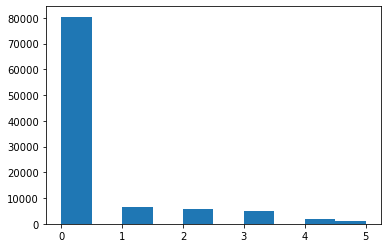

In [14]:
plt.hist(ratings["buy_level"], bins = np.arange(0,5.5,0.5))

(array([0.0000e+00, 0.0000e+00, 3.7000e+01, 0.0000e+00, 1.3970e+03,
        0.0000e+00, 2.5910e+03, 0.0000e+00, 7.1930e+03, 8.9647e+04]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

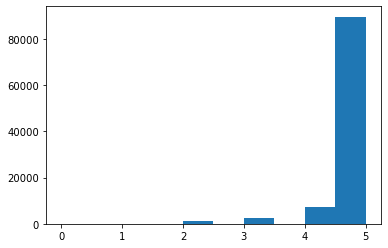

In [15]:
plt.hist(ratings["low_clac"], bins = np.arange(0,5.5,0.5))

(array([ 4787.,     0.,  9618.,     0., 14405.,     0., 19216.,     0.,
        24020., 28819.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

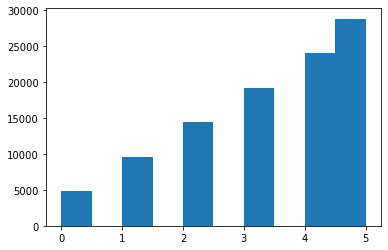

In [16]:
plt.hist(ratings["range_score"], bins = np.arange(0,5.5,0.5))

In [17]:
ratings["score"] = (ratings["buy_level"]*2 + ratings["low_clac"] + ratings["range_score"])/4

(array([5.0000e+00, 3.3900e+02, 4.5230e+03, 1.8121e+04, 3.6707e+04,
        2.9438e+04, 6.0690e+03, 3.8170e+03, 1.4360e+03, 4.1000e+02]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

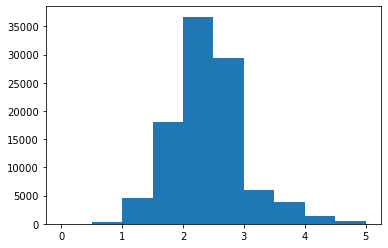

In [18]:
plt.hist(ratings["score"], bins = np.arange(0,5.5,0.5))

# 모델링

## LabelEncoding

In [19]:
le_c = LabelEncoder()
le_c = le_c.fit(ratings.cust)
ratings['cust']=le_c.transform(ratings.cust)
customer_info=pd.DataFrame(le_c.classes_, columns={'cust'})
customer_info['label']=range(0,len(ratings.cust.unique()))
customer_info.to_csv(aa+"_customer_info.csv",index=False)
customer_info

,cust,label
0,M000034966,0
1,M000201112,1
2,M000494848,2
3,M000504230,3
4,M000621637,4
...,...,...
9321,M999213998,9321
9322,M999599111,9322
9323,M999673157,9323
9324,M999770689,9324


In [20]:
le_p = LabelEncoder()
le_p = le_p.fit(ratings.pd_c)
ratings['pd_c']=le_p.transform(ratings.pd_c)
pd_info=pd.DataFrame(le_p.classes_, columns={'pd_c'})
pd_info['label']=range(0,len(ratings.pd_c.unique()))
pd_info.to_csv(aa+"_pd_info.csv",index=False)
pd_info

,pd_c,label
0,PD0032,0
1,PD0034,1
2,PD0044,2
3,PD0060,3
4,PD0070,4
...,...,...
431,PD1925,431
432,PD1926,432
433,PD1928,433
434,PD1929,434


In [21]:
# train test 분리
TRAIN_SIZE = 0.9
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [22]:
users=A0.groupby(['cust','ages','ma_fem_dv'],as_index=False).count()
users=users[['cust','ages','ma_fem_dv']]
users['cust']=le_c.transform(users.cust)
users

,cust,ages,ma_fem_dv
0,0,40대,여성
1,1,50대,여성
2,2,30대,여성
3,3,30대,여성
4,4,40대,여성
...,...,...,...
9321,9321,40대,여성
9322,9322,40대,여성
9323,9323,30대,남성
9324,9324,30대,여성


In [23]:
ages=[]
for i in range(len(users)):
    users.ages[i]=users.ages[i][0:2]
users.ages=users.ages.astype('float')

<ipython-input-23-ab29fe5432dc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users.ages[i]=users.ages[i][0:2]


In [24]:
le_s = LabelEncoder()
le_s = le_s.fit(users.ma_fem_dv)
users['ma_fem_dv']=le_s.transform(users.ma_fem_dv)

customer_info['sex']=users['ma_fem_dv']
customer_info

,cust,label,sex
0,M000034966,0,1
1,M000201112,1,1
2,M000494848,2,1
3,M000504230,3,1
4,M000621637,4,1
...,...,...,...
9321,M999213998,9321,1
9322,M999599111,9322,1
9323,M999673157,9323,0
9324,M999770689,9324,1


In [25]:
users

,cust,ages,ma_fem_dv
0,0,40.0,1
1,1,50.0,1
2,2,30.0,1
3,3,30.0,1
4,4,40.0,1
...,...,...,...
9321,9321,40.0,1
9322,9322,40.0,1
9323,9323,30.0,0
9324,9324,30.0,1


In [26]:
L=len(customer_info)
train_asz = pd.merge(ratings_train, users, on='cust')[['ages','ma_fem_dv']]
test_asz = pd.merge(ratings_test, users, on='cust')[['ages','ma_fem_dv']]

## INPUT file (구매 경험이 없는 고객-상품 모음) 생성

In [27]:
ratings = pd.merge(ratings,users,how="left",on="cust")

#회귀분석을 이용한 score 관련 변수 확인하기
res = ols('score ~ ages+ma_fem_dv', data=ratings).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     155.8
Date:                Sun, 07 Aug 2022   Prob (F-statistic):           2.81e-68
Time:                        00:29:37   Log-Likelihood:                -88907.
No. Observations:              100865   AIC:                         1.778e+05
Df Residuals:                  100862   BIC:                         1.778e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2971      0.007    324.226      0.000       2.283       2.311
ages           0.0003      0.000      1.560      0.119   -7.28e-05       0.001
ma_fem_dv     -0.0650      0.004    -17.547      0.000      -0.072      -0.058
==============================================================================
Omnibus:                    11278.083   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21348.594
Skew:                           0.740   Prob(JB):                         0.00
Kurtosis:                       4.701   Cond. No.                         145.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
ratings.to_csv(aa+"_ratings.csv",index=False,encoding='utf-8-sig')
users.to_csv(aa+"_users.csv",index=False)

In [29]:
check = np.zeros(shape=(len(ratings["cust"].unique()), len(ratings["pd_c"].unique())), dtype=np.int8) - 999


for i in tqdm_notebook(range(len(ratings))):
    c_label = ratings.iloc[i,0]
    p_label = ratings.iloc[i,1]
    sco = ratings.iloc[i,-1]
    check[int(c_label)][int(p_label)] = sco
    
cust = np.where(check == -999)[0]
pd_c = np.where(check == -999)[1]
last = pd.DataFrame()
last["cust"] = cust
last["pd_c"] = pd_c
last = pd.merge(last,users,how="left",on="cust")
last.to_csv(aa+"_input.csv",index=False)

<ipython-input-29-ee852db894de>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(ratings))):


  0%|          | 0/100865 [00:00<?, ?it/s]

## Model Fitting

In [30]:
# Variable 초기화 
K = 200                             # Latent factor 수 
mu = ratings_train.score.mean()    # 전체 평균 
M = ratings.cust.max() + 1       
N = ratings.pd_c.max() + 1  

In [31]:
# Keras model
user = Input(shape=(1, ))
item = Input(shape=(1, ))
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

In [32]:
# Concatenate layers
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

In [33]:
age = Input(shape=(1, ))
age_embedding = Embedding(L, 3, embeddings_regularizer=l2())(age)
age_layer = Flatten()(age_embedding)

sex = Input(shape=(1, ))
sex_embedding = Embedding(L, 3, embeddings_regularizer=l2())(sex)
sex_layer = Flatten()(sex_embedding)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, age_layer,sex_layer])

In [34]:
# Neural network
R = Dense(2048)(R)
R = Activation('relu')(R)
R = Dense(256)(R)
R = Activation('relu')(R)
R = Dense(1)(R)

In [35]:
model = Model(inputs=[user, item, age, sex], outputs=R)
model.compile(
  loss="mse",
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RootMeanSquaredError()]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [36]:
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=3),
             ModelCheckpoint(filepath=aa+'_best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [37]:
# Model fitting
result = model.fit(
  x=[ratings_train.cust.values, ratings_train.pd_c.values, train_asz.ages, train_asz.ma_fem_dv],
  y=ratings_train.score.values - mu,
  epochs=1000,
  batch_size=512,
  validation_data=(
    [ratings_test.cust.values, ratings_test.pd_c.values, test_asz.ages, test_asz.ma_fem_dv],
    ratings_test.score.values - mu
  ), callbacks = callbacks
)

Epoch 1/1000
178/178 [==============================] - 7s 31ms/step - loss: 16.5708 - root_mean_squared_error: 0.5857 - val_loss: 15.9834 - val_root_mean_squared_error: 0.5761
Epoch 2/1000
178/178 [==============================] - 5s 31ms/step - loss: 15.4538 - root_mean_squared_error: 0.5843 - val_loss: 14.9062 - val_root_mean_squared_error: 0.5748
Epoch 3/1000
178/178 [==============================] - 5s 31ms/step - loss: 14.4135 - root_mean_squared_error: 0.5829 - val_loss: 13.9029 - val_root_mean_squared_error: 0.5734
Epoch 4/1000
178/178 [==============================] - 6s 31ms/step - loss: 13.4446 - root_mean_squared_error: 0.5815 - val_loss: 12.9684 - val_root_mean_squared_error: 0.5720
Epoch 5/1000
178/178 [==============================] - 6s 31ms/step - loss: 12.5420 - root_mean_squared_error: 0.5799 - val_loss: 12.0977 - val_root_mean_squared_error: 0.5703
Epoch 6/1000
178/178 [==============================] - 6s 32ms/step - loss: 11.7011 - root_mean_squared_error: 0.5

178/178 [==============================] - 6s 31ms/step - loss: 0.8604 - root_mean_squared_error: 0.4868 - val_loss: 0.8364 - val_root_mean_squared_error: 0.4844
Epoch 48/1000
178/178 [==============================] - 6s 32ms/step - loss: 0.8163 - root_mean_squared_error: 0.4844 - val_loss: 0.7946 - val_root_mean_squared_error: 0.4828
Epoch 49/1000
178/178 [==============================] - 6s 32ms/step - loss: 0.7749 - root_mean_squared_error: 0.4820 - val_loss: 0.7563 - val_root_mean_squared_error: 0.4820
Epoch 50/1000
178/178 [==============================] - 6s 32ms/step - loss: 0.7363 - root_mean_squared_error: 0.4795 - val_loss: 0.7187 - val_root_mean_squared_error: 0.4792
Epoch 51/1000
178/178 [==============================] - 6s 32ms/step - loss: 0.7002 - root_mean_squared_error: 0.4770 - val_loss: 0.6840 - val_root_mean_squared_error: 0.4770
Epoch 52/1000
178/178 [==============================] - 6s 32ms/step - loss: 0.6665 - root_mean_squared_error: 0.4746 - val_loss: 0.6

## 결과 확인

In [38]:
keras_model_best = load_model(aa+'_best_model.h5')

<Figure size 576x576 with 0 Axes>

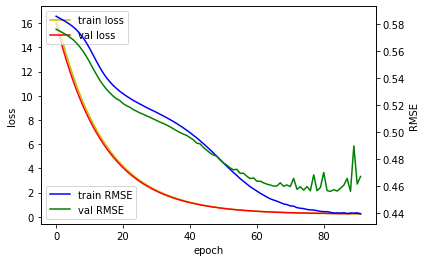

In [39]:
# Plot RMSE
plt.figure(figsize=(8,8))

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(result.history['loss'], 'y', label = 'train loss')
loss_ax.plot(result.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(result.history['root_mean_squared_error'], 'b', label = 'train RMSE')
acc_ax.plot(result.history['val_root_mean_squared_error'], 'g', label = 'val RMSE')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('RMSE')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.savefig(aa+'_model_loss.png')

In [40]:
# Prediction
user_ids = ratings_test.cust.values[100:110]
pd_ids = ratings_test.pd_c.values[100:110]
user_test = test_asz[100:110]
predictions = keras_model_best.predict([user_ids, pd_ids, user_test.ages, user_test.ma_fem_dv]) + mu
print("Actuals: \n", ratings_test[100:110]["score"])
print()
print("Predictions: \n", predictions)

Actuals: 
 56703    2.25
51875    2.50
82178    2.50
20246    2.50
43157    1.50
42921    2.25
55828    2.00
59511    2.50
36359    2.25
29008    3.50
Name: score, dtype: float64

Predictions: 
 [[2.2526066]
 [2.070686 ]
 [2.5509496]
 [2.109288 ]
 [2.69336  ]
 [2.508464 ]
 [1.459465 ]
 [2.2411582]
 [2.538546 ]
 [2.7178807]]


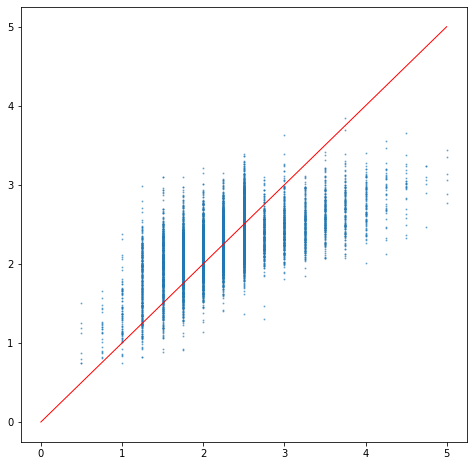

In [41]:
# Pred plot
user_ids = ratings_test.cust.values
pd_ids = ratings_test.pd_c.values
user_test = test_asz
predictions = keras_model_best.predict([user_ids, pd_ids, user_test.ages, user_test.ma_fem_dv]) + mu


plt.figure(figsize=(8,8))
plt.scatter(x = ratings_test.score, y = predictions, s=1, alpha = 0.5)
plt.plot([0, 5], [0, 5], color="red", lw=1, linestyle='solid')
plt.savefig(aa+'_test_predplot.png')

# OUTPUT file 생성

In [42]:
last["pred_score"] = keras_model_best.predict([last["cust"], last["pd_c"], last["ages"], last["ma_fem_dv"]]) + mu

In [43]:
last

,cust,pd_c,ages,ma_fem_dv,pred_score
0,0,0,40.0,1,1.853483
1,0,1,40.0,1,1.755142
2,0,2,40.0,1,1.552598
3,0,3,40.0,1,1.802352
4,0,4,40.0,1,1.652969
...,...,...,...,...,...
3965266,9325,431,20.0,1,1.644290
3965267,9325,432,20.0,1,1.045814
3965268,9325,433,20.0,1,1.697376
3965269,9325,434,20.0,1,1.812458


In [44]:
last.to_csv(aa+"_output.csv",index=False)